# e2e

> Fill in a module description here

In [ ]:
#| default_exp e2e

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
import math

import pandas as pd
from fastai.vision.all import *

from portfolio_search.embeddings import *
from portfolio_search.fileorg import *

In [ ]:
pretrained_data_root = os.getenv('PRETRAINED_DATA_ROOT', '../data/00_RAW/sample')
pretrained_checkpoint = os.getenv('PRETRAINED_CHECKPOINT', 'sample_6epochs')

pretrained_data_root, pretrained_checkpoint

('../data/00_RAW/sample', 'sample_6epochs')

In [ ]:
dls = sketchbook_dataloaders(DATA_01_FLAT / DATASET_FULL_V1)

In [ ]:
learn = sketchbook_resnet34(
    DATA_01_FLAT / DATASET_FULL_V1, FLAT_CHECKPOINTS[DATASET_FULL_V1]
)
learn.model[-1]

['art', 'cover', 'priv', 'xtra']
loading model_20231121_2epochs


RuntimeError: Error(s) in loading state_dict for Sequential:
	size mismatch for 1.8.weight: copying a param with shape torch.Size([5, 512]) from checkpoint, the shape in current model is torch.Size([4, 512]).

In [ ]:
dls = sketchbook_dataloaders(SAMPLE_SKETCHBOOKS_DIR)

test_eq(["art", "cover", "notes"], dls.vocab)

In [ ]:
dls

<fastai.data.core.DataLoaders>

In [ ]:
dls.items[0]

Path('../data/sample/sb44/art/073.jpg')

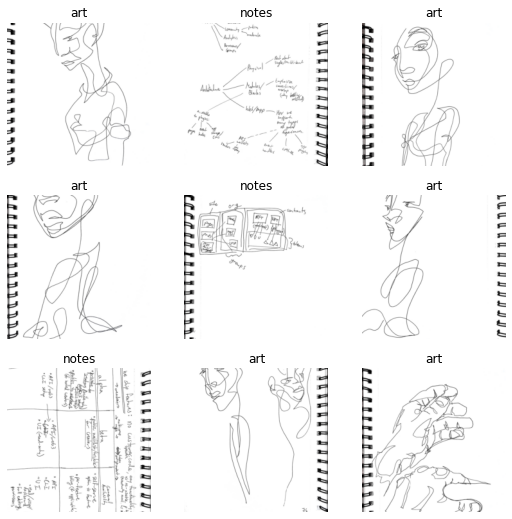

In [ ]:
dls.train.show_batch(max_n=9, ncols=3)

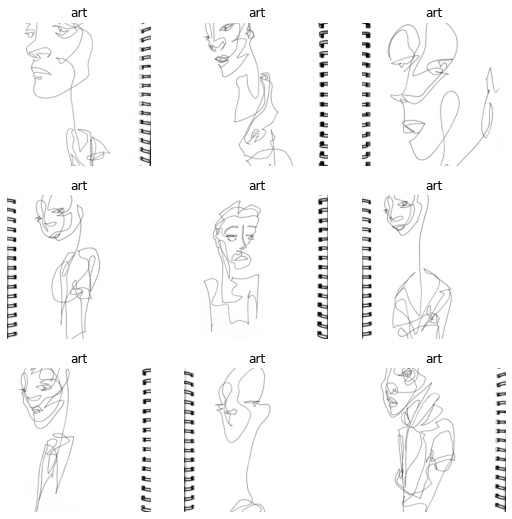

In [ ]:
dls.valid.show_batch(max_n=9, ncols=3)

## Learner

In [ ]:
#| export
def sketchbook_resnet34(sketchbooks_dir, load_checkpoint=None):
    dataloaders = sketchbook_dataloaders(sketchbooks_dir)
    learn = vision_learner(dls, resnet34, metrics=error_rate)
    if load_checkpoint:
        print(f"loading {load_checkpoint}")
        learn.load(load_checkpoint)
    return learn

In [ ]:
# learn = sketchbook_resnet34(SAMPLE_SKETCHBOOKS_DIR)
# learn.fine_tune(6)

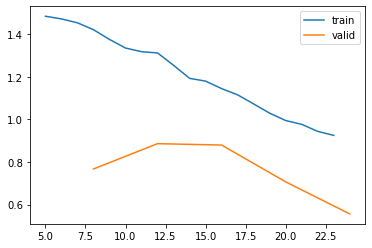

In [ ]:
# learn.recorder.plot_loss()

In [ ]:
# learn.save("SAMPLE_CHECKPOINT")

Path('../data/sample/models/sample_epoch6.pth')

### Load Trained Model

In [ ]:
learn = sketchbook_resnet34(SAMPLE_SKETCHBOOKS_DIR, SAMPLE_CHECKPOINT)
learn.model[-1]

loading sample_epoch6


Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=3, bias=False)
)

In [ ]:
sample_item = learn.dls.train.items[0]

learn.predict(sample_item)

('art', tensor(0), tensor([0.6050, 0.0191, 0.3759]))

<Axes: >

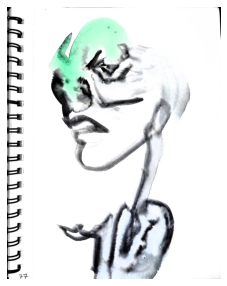

In [ ]:
show_image(Image.open(sample_item))

### Embeddings

In [ ]:
#| export
def batch_fnames_and_images(sketchbooks_dir):
    """
    Prepare data to compute embeddings over all images and store
    them along with a reference to the underlying filename.
    """
    ordered_dls = sketchbook_dataloaders(
        sketchbooks_dir, seed=42, shuffle=False, valid_pct=0.0
    )

    # compute the number of batches
    num_batches = math.ceil(len(ordered_dls.train.items) / DEFAULT_BATCH_SIZE)
    batched_fnames = [
        ordered_dls.train.items[i * 64 : (i + 1) * 64] for i in range(num_batches)
    ]
    print(
        f"total items: {len(ordered_dls.train.items)}, num batches: {len(batched_fnames)}"
    )
    return batched_fnames, ordered_dls

In [ ]:
batched_fnames, ordered_dls = batch_fnames_and_images(SAMPLE_SKETCHBOOKS_DIR)

# ensure all items are in train, none in valid
test_eq(0, len(ordered_dls.valid.items))
test_eq(len(ordered_dls.items), len(ordered_dls.train.items))

# ensure there are the same number of batches
test_eq(num_batches, len(ordered_dls.train))
test_eq(len(batched_fnames), len(ordered_dls.train))
test_eq(DEFAULT_BATCH_SIZE, len(batched_fnames[0]))

total items: 366, num batches: 6


In [ ]:
#| export
def predict_embeddings(model, xb):
    with torch.no_grad():
        with Hook(model[-1][-2]) as hook:
            output = model.eval()(xb)
            act = hook.stored
    return act.cpu().numpy()


class Hook:
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)

    def hook_func(self, m, i, o):
        self.stored = o.detach().clone()

    def __enter__(self, *args):
        return self

    def __exit__(self, *args):
        self.hook.remove()

In [ ]:
train_iter = iter(ordered_dls.train)
x0, y0 = next(train_iter)
print(x0.shape, y0.shape)

activations = predict_embeddings(learn.model, x0)
activations.shape

torch.Size([64, 3, 224, 224]) torch.Size([64])


(64, 512)

In [ ]:
#| hide

## To debug input data, torchvision transform turns tensor back into PIL Image.

# import torchvision.transforms as T
# xform = T.ToPILImage()
# img = xform(x0.squeeze(0))

In [ ]:
#| export
def embed_dir(input_dir, learner):
    batched_fnames, ordered_dls = batch_fnames_and_images(input_dir)
    with torch.no_grad():
        for i, batch in enumerate(zip(batched_fnames, ordered_dls.train)):
            if i > 0:
                break
            batched_fnames, (x, y) = batch
            bs = len(batched_fnames)
            assert bs == x.shape[0]
            assert bs == y.shape[0]

            # activations = predict_embeddings(learn.model, x)
            # assert bs == activations.shape[0]

            for j in range(bs):
                x_j = x[j]
                y_j = y[j]
                fname_j = batched_fnames[j]
                emb_j = activations[j]
                # label: what parent dir exists in the dataset we're processing
                label_j = ordered_dls.vocab[y_j]
                # pred_label: prediction made relative to the vocab of the learner's model
                # (may be different than what's in the dataloader we're using for input).
                pred_label_j, pred_idx_j, pred_probs_j = learn.predict(x_j.cpu())
                yield {
                    "idx": j + i * bs,
                    "fname": fname_j,
                    "label": label_j,
                    "pred_label": pred_label_j,
                    "pred_idx": pred_idx_j.cpu().numpy(),
                    "pred_probs": ",".join(
                        [f"{p:04f}" for p in pred_probs_j.cpu().numpy()]
                    ),
                    "emb_csv": ",".join([str(f) for f in list(emb_j)]),
                }

In [ ]:
rows = []
for x in embed_dir(SAMPLE_SKETCHBOOKS_DIR, learn):
    rows.append(x)
df = pd.DataFrame(rows)

total items: 366, num batches: 6


In [ ]:
df.head()

,idx,fname,label,pred_label,pred_idx,pred_probs,emb_csv
0,0,../data/sample/sb45/art/081.jpg,art,cover,1,"0.253424,0.746451,0.000124","0.95856005,-0.6066226,-0.5562198,-0.5784502,-0.1323025,-0.56148213,0.57790154,-0.60706127,0.64815235,-0.594397,-0.61358374,-0.65156144,0.30152777,-0.6236165,-0.569284,-0.6773242,-0.63575596,1.4439385,0.13333796,-0.62515604,1.9490546,-0.6630973,1.2556934,-0.5628529,0.31702843,-0.6304264,-0.5685409,-0.62586486,-0.26964393,3.2932184,0.23661374,-0.678382,1.0161973,1.2014067,1.6051579,0.7936368,-0.48034564,-0.664829,-0.62973106,-0.57502395,-0.45905814,-0.60106474,-0.5888426,-0.61431277,2.159984,-0.6346218,1.1672144,0.8680809,-0.5397529,0.08189649,-0.65473264,1.4259063,0.72108144,0.6502118,-0.52..."
1,1,../data/sample/sb44/art/104.jpg,art,cover,1,"0.254644,0.745235,0.000121","1.850541,0.5574843,-0.5562198,-0.5950115,0.917613,-0.13226412,0.3155158,-0.60706127,1.4954021,-0.594397,-0.29658055,-0.65156144,-0.59091276,-0.6236165,-0.569284,-0.6773242,-0.63575596,-0.62978005,1.4696196,-0.62515604,0.12178495,-0.64459574,-0.6273176,-0.5628529,-0.65668976,-0.6304264,1.7772518,-0.62586486,-0.5754285,1.1897992,-0.1515162,-0.678382,-0.637526,0.23920768,0.38351563,1.8722337,-0.6034186,0.0035258671,3.0242121,-0.57502395,-0.5788169,0.098439395,-0.5888426,-0.55648553,-0.61142945,-0.6346218,-0.47731483,-0.257248,-0.5397529,-0.6248339,-0.29265612,1.4137433,-0.5758823,0.85690564,-..."
2,2,../data/sample/sb44/art/076.jpg,art,cover,1,"0.253348,0.746531,0.000121","0.9958594,1.0026022,-0.33693552,-0.5950115,-0.098514035,0.35322365,-0.6129129,-0.60706127,0.5249456,-0.594397,-0.61358374,-0.65156144,0.3300359,-0.6236165,-0.569284,-0.6773242,-0.63575596,-0.62978005,-0.5135219,-0.62515604,2.2008572,0.045206726,0.6754911,-0.06371648,-0.65668976,-0.6304264,-0.2247938,-0.62586486,-0.35827854,1.2070622,2.1140723,-0.678382,-0.637526,2.159113,-0.6169512,-0.3028067,1.4844859,-0.35338578,0.93407714,-0.57502395,0.1946734,-0.60106474,-0.04271803,-0.61431277,2.558565,-0.6346218,1.2075441,-0.6048429,0.6799414,0.48702314,-0.65473264,1.0819495,2.2453089,0.031432144,-0...."
3,3,../data/sample/sb46/art/094-nonOverlap.jpg,art,cover,1,"0.252590,0.747292,0.000118","-0.59935933,-0.43156284,-0.5562198,-0.5950115,1.1577172,-0.33151415,2.4634979,-0.60706127,2.1045704,0.96162796,0.095929734,-0.65156144,-0.3270611,-0.6236165,-0.569284,-0.6773242,-0.63575596,-0.62978005,2.0180063,-0.62515604,-0.6202792,0.5561841,0.063713275,-0.5628529,-0.65668976,0.2844189,0.33104,-0.62586486,-0.5754285,1.6547539,0.26530644,-0.678382,0.6142687,-0.65892005,0.354334,-0.4706472,-0.6034186,-0.36233982,2.85207,-0.57502395,0.76418346,-0.60106474,-0.5888426,-0.61431277,0.8958427,-0.6346218,0.86726224,-0.6048429,-0.5397529,0.3214876,-0.65473264,0.7347685,0.6727896,0.2697808,0.95468..."
4,4,../data/sample/sb44/art/089.jpg,art,cover,1,"0.248683,0.751195,0.000122","0.17450038,1.9551328,-0.5562198,-0.5950115,-0.15601183,-0.56148213,-0.6129129,-0.60706127,-0.48721683,-0.594397,0.60617757,-0.65156144,-0.058807403,-0.6236165,-0.123046204,-0.62372303,-0.4065514,-0.62978005,1.5351089,-0.62515604,-0.46879664,-0.6630973,-0.6273176,-0.16714662,-0.65668976,-0.6304264,0.35363212,-0.62586486,0.7942516,-0.63627803,-0.6304714,0.23239303,0.43825728,2.8774126,1.112866,-0.6772992,1.1776797,0.96186674,-0.62973106,-0.57502395,-0.5788169,-0.60106474,-0.5888426,-0.61431277,0.8460195,-0.6346218,1.3322269,-0.6048429,-0.5397529,1.0804161,-0.041072223,0.039224736,-0.5758823,..."


In [ ]:
#| hide
import nbdev

nbdev.nbdev_export()